<h1><center>PHYS-F-303: Partie Numérique</center></h1>
<h1><center>Calcul détaillé des propriétés physiques pour le modèle d'Ising</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

## Question: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

In [1]:
import time,pandas
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

### Calcul des paramètres (Magnétisation, Energie, Capacité calorifique) pour différents couplages

Nous étudions dans ce document une grille $20\times20$ de spins que l'on évolue selon l'algorithme "metropolis".

Nous exploitons la courbe de la capacité calorifique en fonction de du couplage $\alpha=J/kT$ pour déterminer le couplage de transition. Cette courbe doit présenter un pic à la valeur critique de couplage, voir "Computational Physics, J.M.Thijssen".

Nous calculons la capacité calorifique par la relation suivante, valable dans l'ensemble canonique:

$$ c_v = \frac{\text{var}(E)}{kT^2} $$

Les énergies étant déjà exprimées en unités de $J/kT$, nous pouvons porter la variance de l'énergie en fonction de alpha, cette quantité étant proportionelle à $c_v$.

Commençons par importer les fonctions nécessaires, définies dans un fichier séparé.

In [2]:
import Ising_capacalo_jit as Ising

L'initialisation des paramètres de la simulation se fait ici:

In [3]:
NMC = 100+7000 # M et E calculées sur NMC-NMC_eq itérations
NMC_eq = 100
nx = 20
ny = 20
alphas = np.concatenate((np.arange(0,0.34,0.02) , np.arange(0.34,0.41,0.005), np.arange(0.41,0.425,0.001) , \
                         np.arange(0.425,0.445,0.0003), np.arange(0.435,0.45,0.001), np.arange(0.45,0.56,0.005), \
                         np.arange(0.56,1,0.02)))

alphasAbove043 = alphas[np.where(alphas>=0.43)]
resolution = 1/(alphasAbove043[1]-alphasAbove043[0])

np.random.shuffle(alphas) # pour avoir des données utilisables en cours de simulation
a = len(alphas)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = Ising.initial_state_aligned(nx,ny)
    
# Affichage des paramètres choisis
print("Number of alphas: {:d}".format(a))
print("NMC per alpha: {:d}".format(NMC-NMC_eq))
print("Resolution close to the transition: 1/{:.3f}".format(resolution))
    
# Estimation du temps de calcul. Estimation propre à une machine particuliere. Pour estimer le temps de calcul sur 
# votre machine, lancer le calcul de la cellule suivante pour un petit nombre d'itération et modifier ce qui suit.
print("Estimated computation time per grid: {:.2f} hours".format(NMC/20000*a/92*1.00))

Number of alphas: 175
NMC per alpha: 7000
Resolution close to the transition: 1/3333.333
Estimated computation time per grid: 0.68 hours


Décommenter et exécuter la cellule suivante lance le calcul complet:

In [4]:
for i in range(10):
    
    print("run number {:d}".format(i))
    start = time.time()
    #[Ms,Es,VarEs] = Ising.M_equilibrium_for_alphas(
    #    sps,nx,ny,NMC,step,alphas,NMC_eq,"dataIsing/new-dataIsing-Res=3333-NMC=7000-Run={:d}.csv".format(i))
    stop = time.time()
    print(stop-start)

run number 0
2.384185791015625e-06
run number 1
9.5367431640625e-07
run number 2
4.76837158203125e-07
run number 3
4.76837158203125e-07
run number 4
4.76837158203125e-07
run number 5
9.5367431640625e-07
run number 6
9.5367431640625e-07
run number 7
1.6689300537109375e-06
run number 8
9.5367431640625e-07
run number 9
7.152557373046875e-07


L'affichage d'une des courbes obtenues se fait ici:

In [5]:
dataIsing = pandas.read_csv('dataIsing/dataIsing-Res=3333-NMC=7000-Run=0.csv')
[alphas, Ms, Es, VarEs] = np.transpose(dataIsing.as_matrix(['Couplage', '<Magnetisation>', \
                                                            '<Energie>', 'Var(Energie)']))

indices = np.argsort(alphas)
alphas = alphas[indices]
Ms = Ms[indices]
Es = Es[indices]/2 # /2 car nous avions surestimé l'énergie d'un facteur 2 
VarEs = VarEs[indices]/4
Cvs = VarEs # énergie exprimées en kT

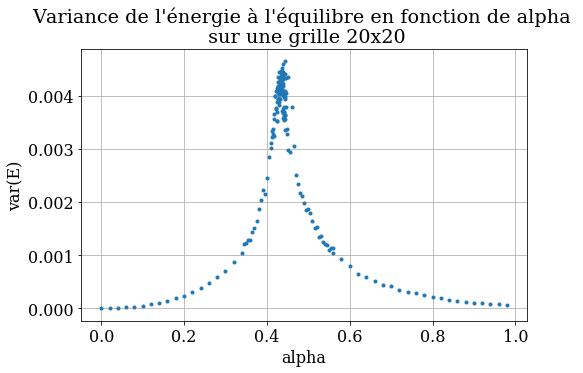

In [6]:
plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.title("Variance de l'énergie à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('var(E)');
#plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

### Fit des données et recherche du maximum

Cherchons à la main les paramètres qui définissent une parabole proches du sommet de la courbe sous la forme 

$$ y = A(x-X_0)^2+C $$

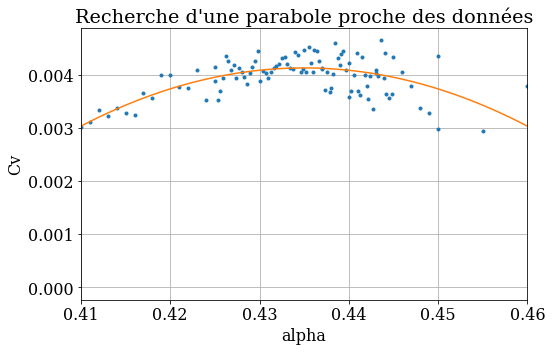

-1.75 0.435 0.004125


In [7]:
A = -7/4
X0 = 0.435
C = 0.0165/4

x = np.linspace(0.41,0.46,100)
y = A*(x-X0)**2+C

plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.plot(x,y, '-');
plt.title("Recherche d'une parabole proche des données".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('Cv');
plt.xlim([0.41,0.46]);
plt.grid();
plt.show()

print(A,X0,C)

Maintenant que nous savons parmi quels coefficients chercher, nous pouvons automatiser le processus avec une fonction cherchant le meilleur fit par moindres carrés. Dans les cellules qui suivent, nous appelons pour chaque grille une fonction qui réalise l'analyse par moindre carré du sommet de la courbe afin de trouver le $\alpha$ critique.

Cette fonction affiche aussi les paramètres fittant le mieux chaque ensemble de données, ce qui nous permet d'affiner l'ensemble de paramètres test original utilisé. 

La fonction calcule l'erreur sur ce qu'elle renvoie en répétant plusieurs fois le calcul sur les données bruitée avec un bruit d'amplitude plausible, i.e. semblable à la variance des données et en regardant la variance des résultats (erreur statistique), ainsi qu'en tenant compte de la résolution utilisée dans les paramètres test (erreur numérique).

Les paramètres test sont bien choisi si l'erreur numérique liée à la finesse de l'échantillonage est petite comparée à l'erreur statistique sur les données récoltées. Ainsi, nous en arrivons à utiliser les paramètres test implémentés dans cette fonction.

Importons la procédure de calcul du alpha critique par la méthode des moindres carrés appliqué à un fit parabolique du sommet de la courbe de la capacité calorifique.

In [8]:
import Least_Squares

Appliquons-la à nos données pour trouver le alpha maximisant la capacité calorifique pour chaque grille de spin étudiée.

In [9]:
nbfichiers = 10

alphas_max = np.empty(nbfichiers)
err_alphas_max = np.empty(nbfichiers)

A_test  = np.linspace(-15.0,-5.0,11)/4
X0_test = np.linspace(0.430,0.440,201) # paramètre le plus pertinent -> plus de points
C_test  = np.linspace(0.0160,0.0170,11)/4

for i in range(nbfichiers):
    
    print("Run {:d}".format(i))
    [alphas_max[i], err_alphas_max[i]] = \
        Least_Squares.moindres_carres_avec_erreur("dataIsing/dataIsing-Res=3333-NMC=7000-Run={:d}.csv"\
            .format(i),A_test,X0_test,C_test)


Run 0
Best fitting parameters: -2.2500 0.4333 0.0042
Le maximum de la parabole de fit se trouve en alpha = 0.43330 +- 0.00016
Erreur numérique: 0.00005 - Erreur Statistique: 0.00015
--------------------------------------------------------------------
Run 1
Best fitting parameters: -1.7500 0.4361 0.0041
Le maximum de la parabole de fit se trouve en alpha = 0.43615 +- 0.00019
Erreur numérique: 0.00005 - Erreur Statistique: 0.00019
--------------------------------------------------------------------
Run 2
Best fitting parameters: -2.2500 0.4330 0.0041
Le maximum de la parabole de fit se trouve en alpha = 0.43295 +- 0.00014
Erreur numérique: 0.00005 - Erreur Statistique: 0.00013
--------------------------------------------------------------------
Run 3
Best fitting parameters: -2.0000 0.4340 0.0041
Le maximum de la parabole de fit se trouve en alpha = 0.43395 +- 0.00016
Erreur numérique: 0.00005 - Erreur Statistique: 0.00015
-----------------------------------------------------------------

Nous voyons que les différentes grilles ne donnent pas les mêmes résultats pour le $\alpha$ critique. Ceux-ci ne rentrent pas dans les intervalles de confiance de leurs voisins. Cela signifie que l'évolution des spins observée dépend fortement de l'état initial de la grille. Selons nous, les spins sont trop fortement corrélés pour que les résultats obtenus en appliquant autant de fois l'algorithme de Metropolis soient assez représentatifs de l'ensemble des états accesibles aux spins par des fluctuations thermique. 

Nous allons donc retenir comme valeur de $\alpha$ critique la moyenne de ces valeurs et estimer l'erreur sur cette moyenne avec la variance des résultats obtenus en faisant varier la grille.

In [10]:
alpha_critique = np.sum(alphas_max)/len(alphas_max)
err_alpha_critique = np.std(alphas_max)

print("Le alpha critique retenu est {:.4f} +- {:.4f}".format(alpha_critique,err_alpha_critique))

Le alpha critique retenu est 0.4336 +- 0.0010
